## data pre-processing and train

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
from PIL import Image
import numpy as np
from sklearn import model_selection


# Specify image folder
dirs = ['IMAGES_COLOR']

# Initialize a list to store pixel values and labels for images
data = []
label = []

# Read and process image files from each folder one by one and add them to the list
for i, d in enumerate(dirs):
    
    # Create a list of files
    files = os.listdir('./NEU-DET/' + d)
    
    for f in files:
        # read Image
        img = Image.open('./NEU-DET/' + d + '/' + f, 'r')
    
        # resize to 128*128
        resize_img = img.resize((200, 200))
        
        # divide in RGB and normalize
        r, g, b = resize_img.split()
        r_resize_img = np.asarray(np.float32(r)/255.0)
        g_resize_img = np.asarray(np.float32(g)/255.0)
        b_resize_img = np.asarray(np.float32(b)/255.0)
        rgb_resize_img = np.asarray([r_resize_img, g_resize_img, b_resize_img])
        
        # Adding a processed image to the list
        data.append(rgb_resize_img)
        
        # Labeling
        if 'crazing' in f:
            i=0
        elif 'inclusion' in f:
            i=1
        elif 'patches' in f:
            i=2
        elif 'pitted_surface' in f:
            i=3
        elif 'rolled-in_scale' in f:
            i=4
        elif 'scratches' in f:
            i=5
        
        # Add Image Labels to the List
        label.append(i)
        
# Make numpy array
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

# data partition
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data, label, test_size=0.3)

# Make torch dtype
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

# Merge
train = TensorDataset(train_X, train_Y)
test = TensorDataset(test_X, test_Y)

# minibatch
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True)


# NN
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:0') # use GPU
#device = torch.device('cpu') # use CPU

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # conv_layer, pooling layer
        self.conv1 = nn.Conv2d(3, 10, 5).to(device) # input, output, filter size
        self.pool = nn.MaxPool2d(2, 2) # pooling size
        self.conv2 = nn.Conv2d(10, 20, 5).to(device)

        # fully connected layer
        self.fc1 = nn.Linear(20*47*47, 120).to(device) # 47=(((((200-5)+1)/2)-5)+1)/2
        self.fc2 = nn.Linear(120, 6).to(device)
    
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*47*47)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# instance
model = Net()

# Loss func object
criterion = nn.CrossEntropyLoss()

# Optimization object
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# fitting
for epoch in range(150): #50, 200, 1000...
    
    total_loss = 0
    
    # data call
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Slope Initialization
        optimizer.zero_grad()
        
        # calc FP
        outputs = model(inputs)
        
        # calc loss
        loss = criterion(outputs, labels)
        
        # calc BP
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # Calc cumulative losses
        total_loss += loss.item()

    # print cum_loss every 50 epochs
    if (epoch+1) % 50 == 0:
        print('Epoch: %d, Total loss: %.6f' % (epoch + 1, total_loss))

print('Finished')

Epoch: 50, Total loss: 10.941312
Epoch: 100, Total loss: 1.805496
Epoch: 150, Total loss: 0.563962
Finished


## test and eval

GroundTruth:  patches inclusion patches inclusion
Predicted:  rolled-in_scale inclusion patches inclusion
Accuracy of the model on test images: 89%


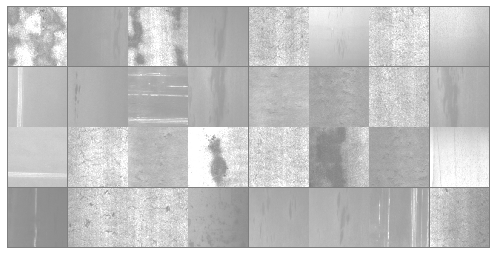

In [3]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu().numpy()    
    image = np.transpose(img, (1, 2, 0))
    
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(image)

#do test
classes = ('crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches')
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images)) #print image

images = images.to(device)
outputs = model(images)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
_, predicted = torch.max(outputs, 1)  # the highest probability
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


#eval accuracy
correct = 0
total = 0

with torch.no_grad():
    
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on test images: %d%%' % (100 * correct / total))

plt.show()